# CDAE

- [Collaborative Denoising Auto-Encoders for Top-N Recommender Systems](https://alicezheng.org/papers/wsdm16-cdae.pdf)

## Experiment

- K-fold 사용

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''
    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
def preprocessing(df: pd.DataFrame, threshold = 3.5) -> pd.DataFrame:
    df = df[df.rating > threshold]
    more_than_4 = df.groupby('userId')['movieId'].nunique()
    more_than_4 = more_than_4.index[more_than_4 > 4]
    df = df[df.userId.isin(more_than_4)]
    return df.reset_index(drop = True)

In [5]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [19]:
def data_split(df: pd.DataFrame, test_size = 0.2) -> pd.DataFrame:
    train, test = train_test_split(df, test_size = test_size, stratify = df.userId, random_state = 7777)
    train, test = map(lambda df: df.reset_index(drop = True), (train, test))
    return train, test

In [20]:
def make_interaction(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [21]:
def make_generator(df: pd.DataFrame,
                   n_item: int,
                   batch_size: int,
                   implicit = False,
                   threshold = 3.5,
                   user_specific = True,
                   corruption = 0.4,
                   negative_sampling = 5) -> Tuple[np.array, Tuple[np.array, np.array]]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                NS = len(pos) * negative_sampling
                neg = np.random.choice(np.delete(np.arange(n_col), pos), NS)
                p = np.random.uniform(0, 1, size = pos.shape)
                corrupt = pos[p < corruption]

                batch[i, pos] = rating[idx]
                batch[i, corrupt] = 0
                batch[i, neg] = np.finfo(float).eps
            
            if user_specific:
                yield (batch, batch_Id), batch
            else:
                yield batch, batch

In [22]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = tf.cast(tf.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1) / K.sum(mask_true, axis = -1)

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)
   
def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    ce = y_true * K.log(y_pred + K.epsilon()) + (1 - y_true) * K.log(1 - y_pred + K.epsilon())
    masked_ce = mask_true * ce
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

In [23]:
def CDAE(n_user: int,
         n_item: int,
         latent_dim = 50,
         activation = 'linear',
         optimizer = 'adam',
         learning_rate = 0.001,
         kernel_initializer = None,
         kernel_regularizer = None,
         user_specific = True) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)

    if user_specific:
        users = u = Input(shape = (1, ), dtype = 'int32', name = 'user')
        u = Embedding(input_dim = n_user, output_dim = latent_dim, input_length = 1, embeddings_regularizer = kernel_regularizer)(u)
        u = Flatten()(u)
        x = concatenate([x, u], axis = 1)
    
    outputs = Dense(n_item, activation = 'sigmoid', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)
    if user_specific:
        model = Model(inputs = [inputs, users], outputs = outputs)
    else:
        model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = masked_cross_entropy, metrics = [masked_cross_entropy, masked_rmse])
    return model

In [24]:
def make_predictor(df: pd.DataFrame, 
                   models: list, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 3.5,
                   user_specific = True,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r > threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = np.zeros(shape = (batch_Id.size, n_col))
        if user_specific:
            for model in models:
                y_pred += model.predict([y_true, batch_Id], verbose = 0)
        else:
            for model in models:
                y_pred += model.predict(y_true, verbose = 0)
        y_pred /= len(models)
        pred = np.argsort(np.where(y_true == 1, 0, 1) * y_pred, axis = -1)[:, :-top_N-1:-1]
        res.append(pred)
    return np.concatenate(res)

In [25]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_metric', 'val_masked_metric'], loc = 'upper right')
    plt.show()

In [48]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    for i, r in enumerate(rec):
        idcg += 1.0 / np.log(i + 2)
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

## 2. DAE

In [26]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = False)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 512)               1897984   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1901178   
Total params: 3,799,162
Trainable params: 3,799,162
Non-trainable params: 0
_________________________________________________________________


In [27]:
train, test = data_split(ratings)
train, test = map(make_interaction, (train, test))

In [28]:
epochs = 100
batch_size = 128

n_splits = 5
folds = KFold(n_splits = n_splits, shuffle = True, random_state = 7777)

Start learning 0-th fold...
Epoch 1/100
38/38 [==============================] - 1s 35ms/step - loss: 1.1519 - masked_cross_entropy: 0.4640 - masked_rmse: 0.3722 - val_loss: 0.7876 - val_masked_cross_entropy: 0.3250 - val_masked_rmse: 0.2955
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 0.6304 - masked_cross_entropy: 0.3083 - masked_rmse: 0.2894 - val_loss: 0.5060 - val_masked_cross_entropy: 0.2944 - val_masked_rmse: 0.2823
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4403 - masked_cross_entropy: 0.2796 - masked_rmse: 0.2754 - val_loss: 0.3902 - val_masked_cross_entropy: 0.2680 - val_masked_rmse: 0.2698
Epoch 4/100
38/38 [==============================] - 1s 33ms/step - loss: 0.3583 - masked_cross_entropy: 0.2556 - masked_rmse: 0.2635 - val_loss: 0.3363 - val_masked_cross_entropy: 0.2496 - val_masked_rmse: 0.2604
Epoch 5/100
38/38 [==============================] - 1s 32ms/step - loss: 0.3217 - masked_cross_entropy: 0.2441 - ma

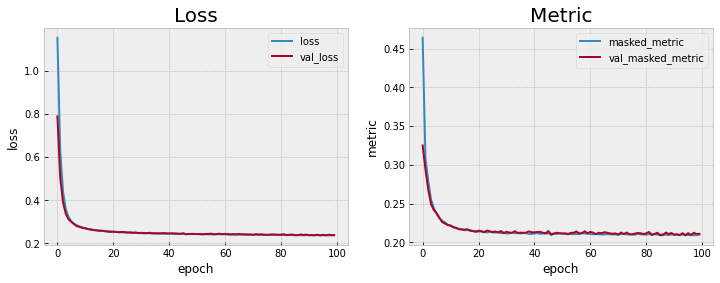

Start learning 1-th fold...
Epoch 1/100
38/38 [==============================] - 1s 33ms/step - loss: 1.1557 - masked_cross_entropy: 0.4658 - masked_rmse: 0.3729 - val_loss: 0.7880 - val_masked_cross_entropy: 0.3225 - val_masked_rmse: 0.2942
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 0.6333 - masked_cross_entropy: 0.3088 - masked_rmse: 0.2896 - val_loss: 0.5067 - val_masked_cross_entropy: 0.2939 - val_masked_rmse: 0.2831
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4411 - masked_cross_entropy: 0.2789 - masked_rmse: 0.2749 - val_loss: 0.3907 - val_masked_cross_entropy: 0.2675 - val_masked_rmse: 0.2699
Epoch 4/100
38/38 [==============================] - 1s 33ms/step - loss: 0.3585 - masked_cross_entropy: 0.2551 - masked_rmse: 0.2631 - val_loss: 0.3361 - val_masked_cross_entropy: 0.2492 - val_masked_rmse: 0.2601
Epoch 5/100
38/38 [==============================] - 1s 31ms/step - loss: 0.3223 - masked_cross_entropy: 0.2446 - ma

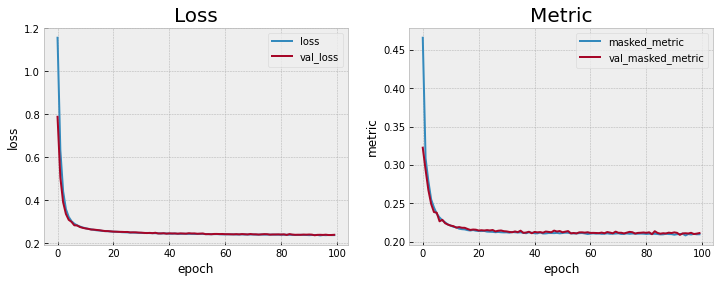

Start learning 2-th fold...
Epoch 1/100
38/38 [==============================] - 1s 34ms/step - loss: 1.1509 - masked_cross_entropy: 0.4599 - masked_rmse: 0.3696 - val_loss: 0.7962 - val_masked_cross_entropy: 0.3305 - val_masked_rmse: 0.2956
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 0.6309 - masked_cross_entropy: 0.3067 - masked_rmse: 0.2886 - val_loss: 0.5106 - val_masked_cross_entropy: 0.2978 - val_masked_rmse: 0.2836
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4389 - masked_cross_entropy: 0.2771 - masked_rmse: 0.2739 - val_loss: 0.3928 - val_masked_cross_entropy: 0.2697 - val_masked_rmse: 0.2694
Epoch 4/100
38/38 [==============================] - 1s 31ms/step - loss: 0.3586 - masked_cross_entropy: 0.2554 - masked_rmse: 0.2632 - val_loss: 0.3406 - val_masked_cross_entropy: 0.2540 - val_masked_rmse: 0.2623
Epoch 5/100
38/38 [==============================] - 1s 30ms/step - loss: 0.3213 - masked_cross_entropy: 0.2439 - ma

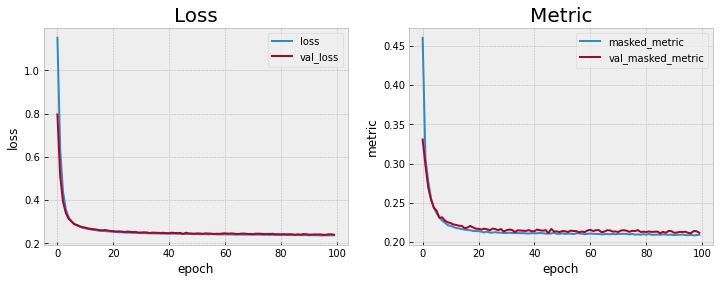

Start learning 3-th fold...
Epoch 1/100
38/38 [==============================] - 1s 38ms/step - loss: 1.1506 - masked_cross_entropy: 0.4607 - masked_rmse: 0.3707 - val_loss: 0.7859 - val_masked_cross_entropy: 0.3206 - val_masked_rmse: 0.2936
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 0.6333 - masked_cross_entropy: 0.3090 - masked_rmse: 0.2892 - val_loss: 0.5047 - val_masked_cross_entropy: 0.2920 - val_masked_rmse: 0.2829
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4418 - masked_cross_entropy: 0.2801 - masked_rmse: 0.2755 - val_loss: 0.3873 - val_masked_cross_entropy: 0.2640 - val_masked_rmse: 0.2680
Epoch 4/100
38/38 [==============================] - 1s 31ms/step - loss: 0.3598 - masked_cross_entropy: 0.2563 - masked_rmse: 0.2637 - val_loss: 0.3369 - val_masked_cross_entropy: 0.2507 - val_masked_rmse: 0.2614
Epoch 5/100
38/38 [==============================] - 1s 34ms/step - loss: 0.3217 - masked_cross_entropy: 0.2443 - ma

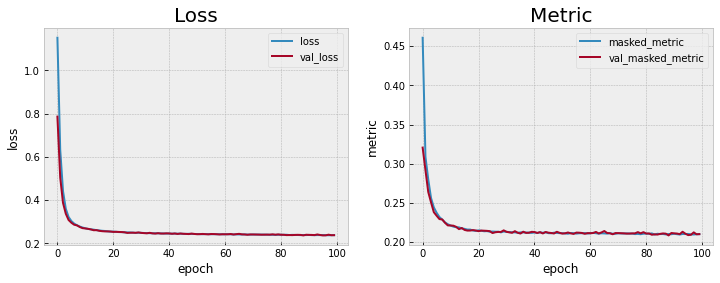

Start learning 4-th fold...
Epoch 1/100
38/38 [==============================] - 1s 35ms/step - loss: 1.1521 - masked_cross_entropy: 0.4625 - masked_rmse: 0.3712 - val_loss: 0.7907 - val_masked_cross_entropy: 0.3266 - val_masked_rmse: 0.2976
Epoch 2/100
38/38 [==============================] - 1s 34ms/step - loss: 0.6302 - masked_cross_entropy: 0.3065 - masked_rmse: 0.2885 - val_loss: 0.5092 - val_masked_cross_entropy: 0.2965 - val_masked_rmse: 0.2844
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4395 - masked_cross_entropy: 0.2776 - masked_rmse: 0.2746 - val_loss: 0.3924 - val_masked_cross_entropy: 0.2690 - val_masked_rmse: 0.2694
Epoch 4/100
38/38 [==============================] - 1s 30ms/step - loss: 0.3575 - masked_cross_entropy: 0.2544 - masked_rmse: 0.2628 - val_loss: 0.3392 - val_masked_cross_entropy: 0.2525 - val_masked_rmse: 0.2611
Epoch 5/100
38/38 [==============================] - 1s 31ms/step - loss: 0.3216 - masked_cross_entropy: 0.2442 - ma

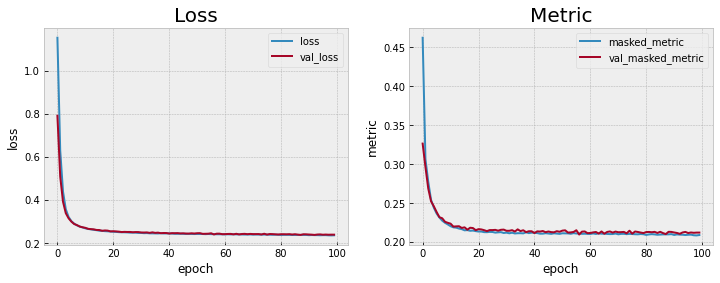

In [29]:
total_hist = []
for i, (train_idx, valid_idx) in enumerate(folds.split(train)):
    print(f'Start learning {i}-th fold...')
    train_f, valid_f = train.iloc[train_idx], train.iloc[valid_idx]
    train_f, valid_f = map(lambda df: df.reset_index(drop = True), (train_f, valid_f))
    train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train_f, valid_f))
    steps_per_epoch = train_f.index.size // batch_size + 1
    validation_steps = valid_f.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = False)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'DAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'masked_cross_entropy')
    total_hist.append(hist)

In [54]:
print('The average of masked_cross_entropy:', np.mean([h.history['val_masked_cross_entropy'][-1] for h in total_hist]))

The average of masked_cross_entropy: 0.2114787995815277


In [55]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(n_splits)]

pred = make_predictor(train, models, n_item, batch_size, user_specific = False)
pred

array([[  26,  167,   40, ...,  207,  105,   48],
       [  23,  167,   92, ...,   26,  186,  156],
       [ 124,   22,   92, ...,   50,   97,  714],
       ...,
       [ 104,    0,  134, ...,  531,  124,   15],
       [ 719, 1195,  723, ...,  633, 1448, 1278],
       [ 559, 1240,  321, ..., 1231, 1450,   63]])

In [56]:
m_ndcg = 0
m_recall = 0
m_precision = 0
map_k = 0
for i in range(len(pred)):
    rec = pred[i]
    gt = test.at[i, 'movieId']
    m_ndcg += ndcg(gt, rec)
    m_recall += recall(gt, rec)
    m_precision += precision(gt, rec)
    map_k += AP_k(gt, rec)
m_ndcg /= len(pred)
m_recall /= len(pred)
m_precision /= len(pred)
map_k /= len(pred)

In [57]:
m_ndcg

0.20400689233880975

In [58]:
m_recall

0.227846532794422

In [59]:
m_precision

0.17344216108717167

In [60]:
map_k

0.1504880389998893

## 3. CDAE

In [38]:
model = CDAE(n_user, n_item, latent_dim = 512, user_specific = True)
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 512)       3092480     user[0][0]                       
__________________________________________________________________________________________________
encoder (Dense)                 (None, 512)          1897984     input[0][0]                      
______________________________________________________________________________________

In [39]:
train, test = data_split(ratings)
train, test = map(make_interaction, (train, test))

In [40]:
epochs = 100
batch_size = 128

n_splits = 5
folds = KFold(n_splits = n_splits, shuffle = True, random_state = 7777)

Start learning 0-th fold...
Epoch 1/100
38/38 [==============================] - 1s 34ms/step - loss: 1.1507 - masked_cross_entropy: 0.4619 - masked_rmse: 0.3707 - val_loss: 0.7883 - val_masked_cross_entropy: 0.3252 - val_masked_rmse: 0.2966
Epoch 2/100
38/38 [==============================] - 1s 34ms/step - loss: 0.6318 - masked_cross_entropy: 0.3086 - masked_rmse: 0.2896 - val_loss: 0.5063 - val_masked_cross_entropy: 0.2938 - val_masked_rmse: 0.2820
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4398 - masked_cross_entropy: 0.2781 - masked_rmse: 0.2744 - val_loss: 0.3909 - val_masked_cross_entropy: 0.2678 - val_masked_rmse: 0.2696
Epoch 4/100
38/38 [==============================] - 1s 32ms/step - loss: 0.3581 - masked_cross_entropy: 0.2548 - masked_rmse: 0.2629 - val_loss: 0.3374 - val_masked_cross_entropy: 0.2506 - val_masked_rmse: 0.2608
Epoch 5/100
38/38 [==============================] - 1s 30ms/step - loss: 0.3219 - masked_cross_entropy: 0.2443 - ma

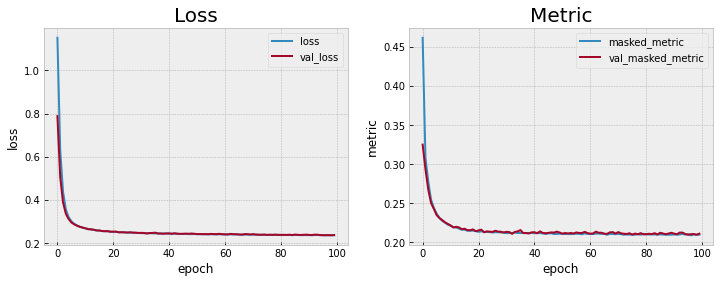

Start learning 1-th fold...
Epoch 1/100
38/38 [==============================] - 1s 35ms/step - loss: 1.1519 - masked_cross_entropy: 0.4610 - masked_rmse: 0.3703 - val_loss: 0.7875 - val_masked_cross_entropy: 0.3225 - val_masked_rmse: 0.2954
Epoch 2/100
38/38 [==============================] - 1s 31ms/step - loss: 0.6321 - masked_cross_entropy: 0.3079 - masked_rmse: 0.2894 - val_loss: 0.5033 - val_masked_cross_entropy: 0.2895 - val_masked_rmse: 0.2801
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4409 - masked_cross_entropy: 0.2784 - masked_rmse: 0.2748 - val_loss: 0.3881 - val_masked_cross_entropy: 0.2643 - val_masked_rmse: 0.2673
Epoch 4/100
38/38 [==============================] - 1s 35ms/step - loss: 0.3592 - masked_cross_entropy: 0.2557 - masked_rmse: 0.2633 - val_loss: 0.3363 - val_masked_cross_entropy: 0.2495 - val_masked_rmse: 0.2599
Epoch 5/100
38/38 [==============================] - 1s 32ms/step - loss: 0.3211 - masked_cross_entropy: 0.2432 - ma

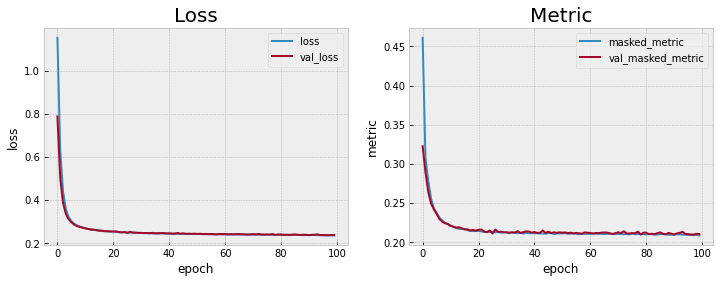

Start learning 2-th fold...
Epoch 1/100
38/38 [==============================] - 1s 34ms/step - loss: 1.1526 - masked_cross_entropy: 0.4640 - masked_rmse: 0.3724 - val_loss: 0.7959 - val_masked_cross_entropy: 0.3316 - val_masked_rmse: 0.2957
Epoch 2/100
38/38 [==============================] - 1s 30ms/step - loss: 0.6304 - masked_cross_entropy: 0.3072 - masked_rmse: 0.2890 - val_loss: 0.5105 - val_masked_cross_entropy: 0.2986 - val_masked_rmse: 0.2841
Epoch 3/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4401 - masked_cross_entropy: 0.2792 - masked_rmse: 0.2751 - val_loss: 0.3913 - val_masked_cross_entropy: 0.2694 - val_masked_rmse: 0.2700
Epoch 4/100
38/38 [==============================] - 1s 34ms/step - loss: 0.3574 - masked_cross_entropy: 0.2547 - masked_rmse: 0.2629 - val_loss: 0.3426 - val_masked_cross_entropy: 0.2560 - val_masked_rmse: 0.2634
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.3224 - masked_cross_entropy: 0.2451 - ma

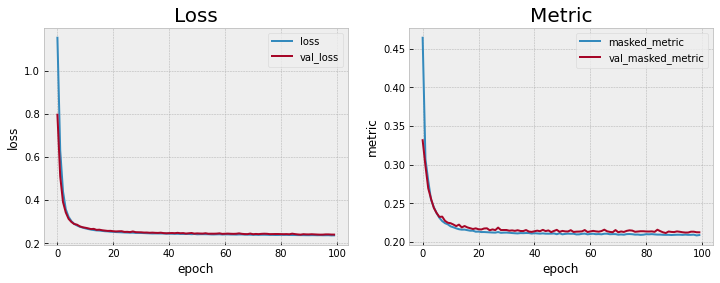

Start learning 3-th fold...
Epoch 1/100
38/38 [==============================] - 1s 33ms/step - loss: 1.1513 - masked_cross_entropy: 0.4620 - masked_rmse: 0.3706 - val_loss: 0.7845 - val_masked_cross_entropy: 0.3209 - val_masked_rmse: 0.2956
Epoch 2/100
38/38 [==============================] - 1s 30ms/step - loss: 0.6320 - masked_cross_entropy: 0.3087 - masked_rmse: 0.2896 - val_loss: 0.5051 - val_masked_cross_entropy: 0.2923 - val_masked_rmse: 0.2817
Epoch 3/100
38/38 [==============================] - 1s 33ms/step - loss: 0.4397 - masked_cross_entropy: 0.2780 - masked_rmse: 0.2744 - val_loss: 0.3840 - val_masked_cross_entropy: 0.2614 - val_masked_rmse: 0.2667
Epoch 4/100
38/38 [==============================] - 1s 34ms/step - loss: 0.3590 - masked_cross_entropy: 0.2562 - masked_rmse: 0.2636 - val_loss: 0.3363 - val_masked_cross_entropy: 0.2502 - val_masked_rmse: 0.2612
Epoch 5/100
38/38 [==============================] - 1s 32ms/step - loss: 0.3216 - masked_cross_entropy: 0.2441 - ma

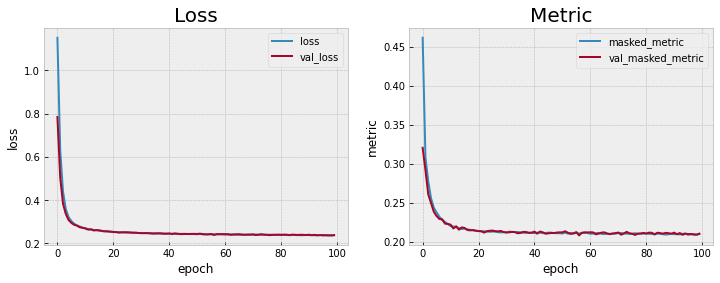

Start learning 4-th fold...
Epoch 1/100
38/38 [==============================] - 1s 34ms/step - loss: 1.1497 - masked_cross_entropy: 0.4607 - masked_rmse: 0.3702 - val_loss: 0.7919 - val_masked_cross_entropy: 0.3277 - val_masked_rmse: 0.2972
Epoch 2/100
38/38 [==============================] - 1s 30ms/step - loss: 0.6293 - masked_cross_entropy: 0.3060 - masked_rmse: 0.2881 - val_loss: 0.5102 - val_masked_cross_entropy: 0.2978 - val_masked_rmse: 0.2847
Epoch 3/100
38/38 [==============================] - 1s 33ms/step - loss: 0.4388 - masked_cross_entropy: 0.2774 - masked_rmse: 0.2742 - val_loss: 0.3928 - val_masked_cross_entropy: 0.2702 - val_masked_rmse: 0.2699
Epoch 4/100
38/38 [==============================] - 1s 34ms/step - loss: 0.3575 - masked_cross_entropy: 0.2543 - masked_rmse: 0.2626 - val_loss: 0.3375 - val_masked_cross_entropy: 0.2506 - val_masked_rmse: 0.2605
Epoch 5/100
38/38 [==============================] - 1s 31ms/step - loss: 0.3210 - masked_cross_entropy: 0.2436 - ma

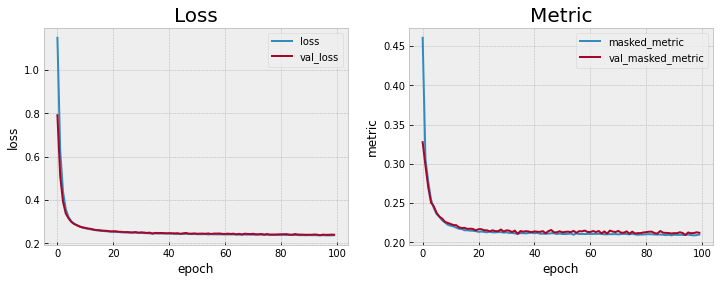

In [42]:
total_hist = []
for i, (train_idx, valid_idx) in enumerate(folds.split(train)):
    print(f'Start learning {i}-th fold...')
    train_f, valid_f = train.iloc[train_idx], train.iloc[valid_idx]
    train_f, valid_f = map(lambda df: df.reset_index(drop = True), (train_f, valid_f))
    train_gen, valid_gen = map(lambda x: make_generator(x, n_item, batch_size, implicit = True, user_specific = False), (train_f, valid_f))
    steps_per_epoch = train_f.index.size // batch_size + 1
    validation_steps = valid_f.index.size // batch_size + 1

    optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
    model = CDAE(n_user, n_item, latent_dim = 512, optimizer = optimizer, user_specific = False)

    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
    model_checkpoint = ModelCheckpoint(f'CDAE_{i+1}.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                     verbose = 1, callbacks = [early_stopping, model_checkpoint])
    show_history(hist, 'loss', 'masked_cross_entropy')
    total_hist.append(hist)

In [44]:
print('The average of masked_cross_entropy:', np.mean([h.history['val_masked_cross_entropy'][-1] for h in total_hist]))

The average of masked_cross_entropy: 0.2114787995815277


In [45]:
models = [load_model(f'DAE_{i+1}.h5', compile = False) for i in range(n_splits)]

pred = make_predictor(train, models, n_item, batch_size, user_specific = False)
pred

array([[  26,  167,   40, ...,  207,  105,   48],
       [  23,  167,   92, ...,   26,  186,  156],
       [ 124,   22,   92, ...,   50,   97,  714],
       ...,
       [ 104,    0,  134, ...,  531,  124,   15],
       [ 719, 1195,  723, ...,  633, 1448, 1278],
       [ 559, 1240,  321, ..., 1231, 1450,   63]])

In [49]:
m_ndcg = 0
m_recall = 0
m_precision = 0
map_k = 0
for i in range(len(pred)):
    rec = pred[i]
    gt = test.at[i, 'movieId']
    m_ndcg += ndcg(gt, rec)
    m_recall += recall(gt, rec)
    m_precision += precision(gt, rec)
    map_k += AP_k(gt, rec)
m_ndcg /= len(pred)
m_recall /= len(pred)
m_precision /= len(pred)
map_k /= len(pred)

In [50]:
m_ndcg

0.20400689233880975

In [51]:
m_recall

0.227846532794422

In [52]:
m_precision

0.17344216108717167

In [53]:
map_k

0.1504880389998893